In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from matplotlib.colors import ListedColormap

def show(image, instances=None, title=None, visualize_bboxes=True, figsize=(10, 15)):
    image_np = np.asarray(image)

    # Создаём фигуру
    plt.figure(figsize=figsize)
    plt.imshow(image_np)
    plt.axis('off')

    # Определяем цвета
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
    colormap = ListedColormap(colors[:len(instances) if instances else 0])

    ax = plt.gca()

    # Визуализируем маски и вычисляем bounding boxes, если нужно
    if instances is not None:
        for i, instance in enumerate(instances):
            mask = instance.get('mask')
            bbox = instance.get('bbox')
            score = instance.get('score')
            label = instance.get('text_label') or instance.get('label')

            color = colors[i % len(colors)]  # Выбор цвета

            if mask is not None:
                mask_colored = np.zeros((*mask.shape, 4))  # Для RGBA
                cmap_color = plt.colormaps.get_cmap(colormap)(i)  # Получение цвета
                mask_colored[..., :3] = cmap_color[:3]  # Устанавливаем RGB
                mask_colored[..., 3] = 0.3 * mask  # Прозрачность для наложения
                plt.imshow(mask_colored)

                if bbox is None:  # Вычисляем bbox из маски, если его нет
                    rows = np.any(mask, axis=1)
                    cols = np.any(mask, axis=0)
                    if np.any(rows) and np.any(cols):
                        y_min, y_max = np.where(rows)[0][[0, -1]]
                        x_min, x_max = np.where(cols)[0][[0, -1]]
                        bbox = [x_min, y_min, x_max, y_max]

            if visualize_bboxes and bbox is not None:
                x_min, y_min, x_max, y_max = bbox
                width = x_max - x_min
                height = y_max - y_min

                # Рисуем прямоугольник
                rect = patches.Rectangle((x_min, y_min), width, height,
                                          linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                # Определяем подпись
                text_label = ''
                if label is not None:
                    text_label = str(label)

                if score is not None:
                    text_label = f'{label or "Score"}: {score:.2f}'

                # Добавляем подпись, если она есть
                if text_label:
                    ax.text(x_min, y_min - 5, text_label, color='white', fontsize=10,
                            bbox=dict(facecolor=color, alpha=0.5, edgecolor='none', pad=2))

    # Добавляем заголовок, если есть
    if title is not None:
        plt.title(title)

    # Показываем изображение
    plt.tight_layout()
    plt.show()

In [3]:
from ultralytics import YOLO

model = YOLO("yolo/runs/train/laser_seg_model/weights/best.pt")

In [185]:
sample_image_path = r'data\raw\Положение 5\Image__2025-07-15__15-55-36.bmp'
sample_image = Image.open(sample_image_path)


In [186]:
predict = model.predict(sample_image)[0]
masks = predict.masks.data.cpu().numpy().astype(int)
labels = predict.boxes.cls.cpu().numpy().astype(int)

edge_mask = masks[np.where(labels == 0)[0][0].item()] if 0 in labels else None
platform_mask = masks[np.where(labels == 1)[0][0].item()] if 1 in labels else None
object_mask = masks[np.where(labels == 2)[0][0].item()] if 2 in labels else None


0: 352x640 1 0, 1 1, 1 2, 9.1ms
Speed: 3.8ms preprocess, 9.1ms inference, 3.5ms postprocess per image at shape (1, 3, 352, 640)


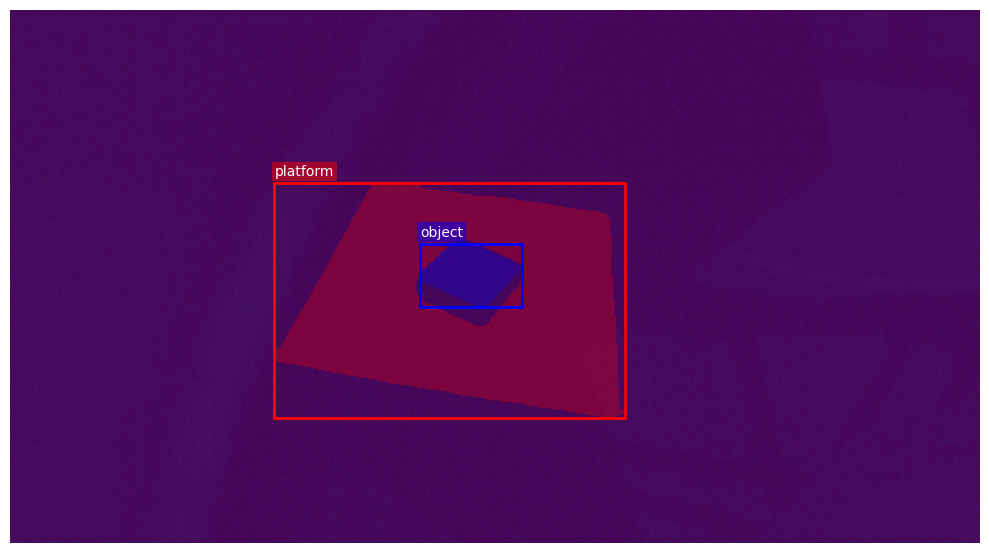

In [187]:
instances = [
    # {'label': 'edge', 'mask': edge_mask},
    {'label': 'platform', 'mask': platform_mask},
    {'label': 'object', 'mask': object_mask}
]
show(sample_image, instances)

In [219]:
import cv2
import numpy as np

def get_points(mask: np.ndarray,
                           eps_start: float = 0.01,
                           eps_step: float = 0.005,
                           eps_max: float = 0.1):
    # 1. Подготовка изображения
    img = (mask.astype(np.uint8) * 255)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("Не найдено ни одного контура — проверьте маску.")
    contour = max(contours, key=cv2.contourArea)
    perimeter = cv2.arcLength(contour, True)

    # 2. Цикл подбора epsilon
    eps = eps_start
    approx = None
    while eps <= eps_max:
        approx = cv2.approxPolyDP(contour, eps * perimeter, True)
        if len(approx) == 4:
            break
        eps += eps_step

    if approx is None or len(approx) != 4:
        raise RuntimeError(
            f"Не удалось получить 4 вершины: попробовали eps от {eps_start:.3f} до {eps_max:.3f}"
        )

    # 3. Преобразуем и упорядочим вершины
    corners = approx.reshape(-1, 2)
    s = corners.sum(axis=1)
    diff = np.diff(corners, axis=1).reshape(-1)
    ordered = np.zeros((4,2), dtype=int)
    ordered[0] = corners[np.argmin(s)]    # левый-верх
    ordered[2] = corners[np.argmax(s)]    # правый-низ
    ordered[1] = corners[np.argmin(diff)] # правый-верх
    ordered[3] = corners[np.argmax(diff)] # левый-низ

    return ordered

def visualize_mask_with_points(image, pointss):
    image_np = np.asarray(image).copy()

    for points in pointss:
        # Нарисуем контур
        cv2.polylines(image_np, [points.reshape((-1, 1, 2))], isClosed=True, color=(0, 255, 0), thickness=2)

        # Нарисуем точки
        for i, (x, y) in enumerate(points):
            cv2.circle(image_np, (x, y), radius=5, color=(0, 0, 255), thickness=-1)
            cv2.putText(image_np, f"{i+1}", (x+5, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Показываем через matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(image_np, cmap='gray')
    plt.axis('off')
    plt.show()


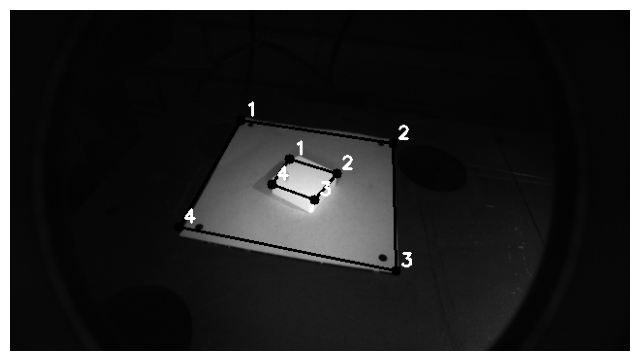

In [221]:
platform_points = get_points(platform_mask)
object_points = get_points(object_mask)
visualize_mask_with_points(sample_image.resize(platform_mask.shape[::-1]), [platform_points, object_points])

In [222]:
import numpy as np
import cv2

# координаты на изображении: array из ваших четырёх точек, dtype=float32
pts_img = platform_points

# «мировые» точки прямоугольника
W, H = 1, 1
pts_world = np.array([[0, 0],
                      [W, 0],
                      [W, H],
                      [0, H]], dtype=np.float32)

H, _ = cv2.findHomography(pts_world, pts_img)

# Берём первые два столбца гомографии
h1 = H[:, 0]
h2 = H[:, 1]

# нормируем
r1 = h1 / np.linalg.norm(h1)
r2 = h2 / np.linalg.norm(h2)

# третий вектор как их векторное произведение
r3 = np.cross(r1, r2)

# Собираем R
R_approx = np.column_stack((r1, r2, r3))

# из R_approx
sy = np.sqrt(R_approx[0,0]**2 + R_approx[1,0]**2)
singular = sy < 1e-6

if not singular:
    pitch = np.arctan2(R_approx[2,1], R_approx[2,2])
    yaw   = np.arctan2(-R_approx[2,0], sy)
    roll  = np.arctan2(R_approx[1,0], R_approx[0,0])
else:
    pitch = np.arctan2(-R_approx[1,2], R_approx[1,1])
    yaw   = np.arctan2(-R_approx[2,0], sy)
    roll  = 0

# в градусы
pitch_deg = np.degrees(pitch)
roll_deg  = np.degrees(roll)

print(f"Приблизительный наклон (pitch): {pitch_deg:.1f}°")
print(f"Приблизительный поворот в плоскости (roll): {roll_deg:.1f}°")

Приблизительный наклон (pitch): -0.3°
Приблизительный поворот в плоскости (roll): 6.8°


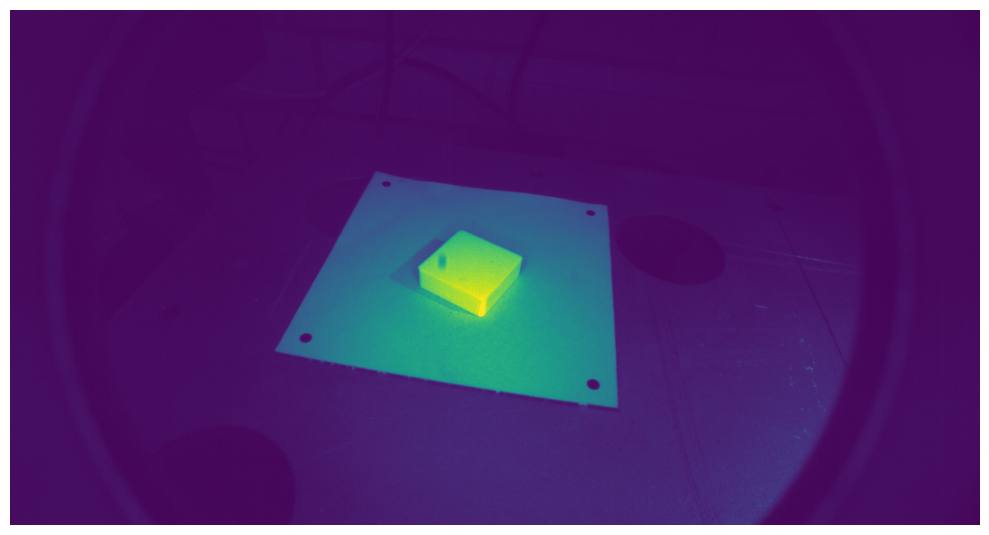

In [223]:
show(sample_image)

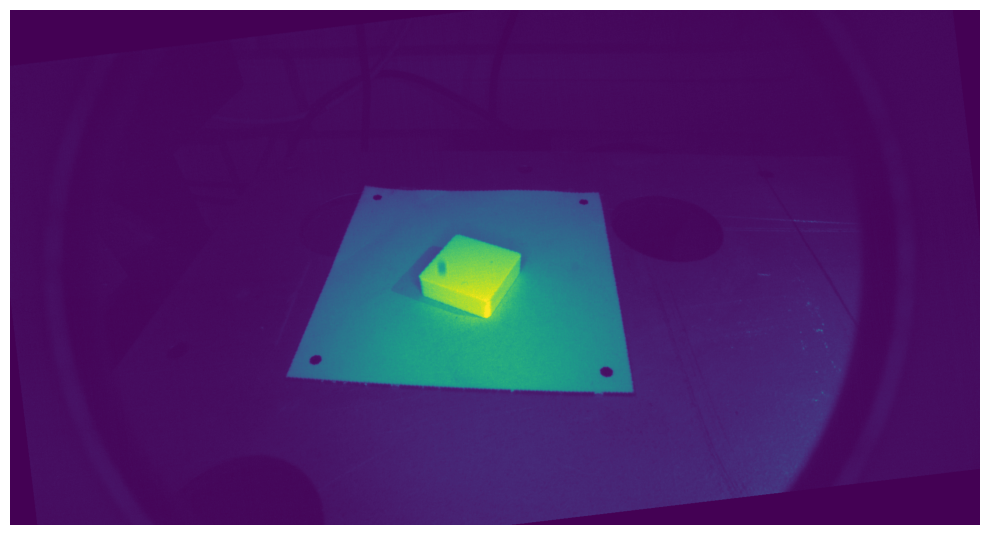

In [224]:
show(sample_image.rotate(roll_deg))

In [174]:
import pandas as pd

pd.read_csv("data/Координаты.csv")

,position,degree,size,coord_x,coord_y
0,1,37,"18×18×5,7",4,6
1,2,0,"18×18×5,7",0,0
2,3,0,"18×18×5,7",30,-2
3,4,15,"18×18×5,7",7,-26
4,5,75,"18×18×5,7",-5,-1
5,6,87,"18×18×5,7",-15,5
6,7,0,"18×18×5,7",8,0
7,8,22,7×18,7,18
8,9,0,"18×18×5,7",4,18
9,10,0,Ø12,-20,19
